In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklift.datasets import fetch_x5

# Получение датасета

In [3]:
dataset = fetch_x5()

data = dataset.data

# Данные обо всех клиентах
clients = data.clients
# Клиенты для обучения
train = data.train           
# Информация о покупках
purchases = data.purchases

# Тритмент
treatement = dataset.treatment
# Целевая переменная
target = dataset.target

In [4]:
# Информация о клиентах
df_clients = pd.concat([train, treatement, target], axis=1)
df_clients = pd.merge(df_clients, clients, left_on='client_id', right_on='client_id')

In [5]:
df_clients

,client_id,treatment_flg,target,first_issue_date,first_redeem_date,age,gender
0,000012768d,0,1,2017-08-05 15:40:48,2018-01-04 19:30:07,45,U
1,000036f903,1,1,2017-04-10 13:54:23,2017-04-23 12:37:56,72,F
2,00010925a5,1,1,2018-07-24 16:21:29,2018-09-14 16:12:49,83,U
3,0001f552b0,1,1,2017-06-30 19:20:38,2018-08-28 12:59:45,33,F
4,00020e7b18,1,1,2017-11-27 11:41:45,2018-01-10 17:50:05,73,U
...,...,...,...,...,...,...,...
200034,fffe0abb97,0,0,2017-11-27 08:56:54,2018-02-11 09:26:08,35,F
200035,fffe0ed719,0,1,2017-09-15 08:53:24,2017-12-12 14:50:12,69,U
200036,fffea1204c,0,1,2018-01-31 16:59:37,2018-03-12 17:02:27,73,F
200037,fffeca6d22,1,0,2017-12-28 11:56:13,NaN,77,F


In [6]:
purchases

,client_id,transaction_id,transaction_datetime,regular_points_received,express_points_received,regular_points_spent,express_points_spent,purchase_sum,store_id,product_id,product_quantity,trn_sum_from_iss,trn_sum_from_red
0,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,9a80204f78,2.0,80.0,NaN
1,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,da89ebd374,1.0,65.0,NaN
2,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,0a95e1151d,1.0,24.0,NaN
3,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,4055b15e4a,2.0,50.0,NaN
4,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,a685f1916b,1.0,22.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
45786563,fffff6ce77,48f6d115ce,2019-03-15 17:47:02,6.7,0.0,0.0,0.0,676.0,5ec64bdccb,24d5a54f42,1.0,164.0,NaN
45786564,fffff6ce77,48f6d115ce,2019-03-15 17:47:02,6.7,0.0,0.0,0.0,676.0,5ec64bdccb,7427d0830d,1.0,134.0,NaN
45786565,fffff6ce77,48f6d115ce,2019-03-15 17:47:02,6.7,0.0,0.0,0.0,676.0,5ec64bdccb,6c547c2ca8,1.0,60.0,NaN
45786566,fffff6ce77,48f6d115ce,2019-03-15 17:47:02,6.7,0.0,0.0,0.0,676.0,5ec64bdccb,d04e7a8338,1.0,48.0,NaN


# Проверка на пропуски

In [7]:
df_clients.isna().sum()

client_id                0
treatment_flg            0
target                   0
first_issue_date         0
first_redeem_date    17546
age                      0
gender                   0
dtype: int64

Пропуски есть только в `first_redeem_date`. Они обозначают, что событие `redeem` никогда не произошло. Их заполнять не надо.

In [8]:
purchases.isna().sum()

client_id                         0
transaction_id                    0
transaction_datetime              0
regular_points_received           0
express_points_received           0
regular_points_spent              0
express_points_spent              0
purchase_sum                      0
store_id                          0
product_id                        0
product_quantity                  0
trn_sum_from_iss                  0
trn_sum_from_red           42743212
dtype: int64

Пропуски есть только в `trn_sum_from_red`, что обозначает стоимость товара до применения баллов. Равно `NaN` там, где человек не применил баллы. Можно восстановить по значению `trn_sum_from_iss` (стоимость товара после применения баллов).

In [9]:
purchases['trn_sum_from_red'] = purchases['trn_sum_from_red'].fillna(purchases['trn_sum_from_iss'])

In [10]:
# Преобразование значение потраченных баллов из отрицательных в положительные (для удобства)
purchases['regular_points_spent'] = purchases['regular_points_spent'].abs()
purchases['express_points_spent'] = purchases['express_points_spent'].abs()

In [11]:
purchases.isna().sum()

client_id                  0
transaction_id             0
transaction_datetime       0
regular_points_received    0
express_points_received    0
regular_points_spent       0
express_points_spent       0
purchase_sum               0
store_id                   0
product_id                 0
product_quantity           0
trn_sum_from_iss           0
trn_sum_from_red           0
dtype: int64

Теперь пропусков нет.

# Распределение таргета

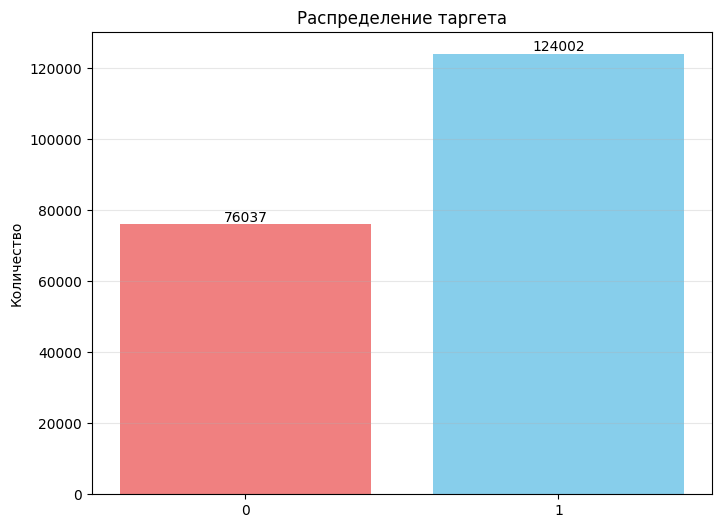

In [12]:
# Подсчет частот
value_counts = target.value_counts().sort_index()

plt.figure(figsize=(8, 6))
plt.bar(value_counts.index, value_counts.values, color=['lightcoral', 'skyblue'])
plt.ylabel('Количество')
plt.title('Распределение таргета')
plt.xticks([0, 1], ['0', '1'])
plt.grid(axis='y', alpha=0.3)

# Добавление подписей с значениями
for i, v in enumerate(value_counts.values):
    plt.text(i, v + 1, str(v), ha='center', va='bottom')

plt.show()

# Feature engineering

In [13]:
class BehavioralFeatureGenerator:
    """
    Класс для генерации агрегированных поведенческих признаков
    на основе транзакционных данных (таблица purchases).
    """
    def __init__(self, purchases_df):
        self.df = purchases_df.copy()

    # Получить уникальные транзакции (без дублирования по product_id)
    def _get_unique_transactions(self):
        cols_to_keep = ['client_id', 'transaction_id', 'transaction_datetime', 
                       'regular_points_received', 'express_points_received',
                       'regular_points_spent', 'express_points_spent', 
                       'purchase_sum', 'store_id']
        
        return self.df[cols_to_keep].drop_duplicates('transaction_id')

    # Получить данные на уровне конкретных продуктов
    def _get_product_level_data(self):
        product_cols = ['client_id', 'transaction_id', 'product_id', 
                       'product_quantity', 'trn_sum_from_iss', 'trn_sum_from_red']
        return self.df[product_cols]

    # Генерация всех фич
    def generate_features(self):
        features = {}
        
        # Базовые фичи по транзакциям
        features.update(self._transaction_features())
        
        # Фичи по баллам
        features.update(self._points_features())
        
        # Фичи по продуктам
        features.update(self._product_features())
        
        # Временные фичи
        features.update(self._time_features())
        
        # Фичи по магазинам
        features.update(self._store_features())
        
        return pd.DataFrame(features)

    # Фичи по транзакциям
    def _transaction_features(self):
        trans_df = self._get_unique_transactions()
        client_trans = trans_df.groupby('client_id')
        
        features = {
            'total_transactions': client_trans.size(),
            'total_purchase_sum': client_trans['purchase_sum'].sum(),
            'avg_transaction_amount': client_trans['purchase_sum'].mean(),
            'std_transaction_amount': client_trans['purchase_sum'].std(),
            'max_transaction_amount': client_trans['purchase_sum'].max(),
            'min_transaction_amount': client_trans['purchase_sum'].min(),
        }
        
        # Квантили
        for q in [0.25, 0.5, 0.75]:
            features[f'transaction_amount_q{q}'] = client_trans['purchase_sum'].quantile(q)
        
        return features

    # Фичи по баллам
    def _points_features(self):
        trans_df = self._get_unique_transactions()
        client_trans = trans_df.groupby('client_id')
        
        features = {
            'total_regular_points_received': client_trans['regular_points_received'].sum(),
            'total_express_points_received': client_trans['express_points_received'].sum(),
            'total_regular_points_spent': client_trans['regular_points_spent'].sum(),
            'total_express_points_spent': client_trans['express_points_spent'].sum(),
            'avg_regular_points_per_transaction': client_trans['regular_points_received'].mean(),
            'avg_express_points_per_transaction': client_trans['express_points_received'].mean(),
            'points_earned_to_spent_ratio': (client_trans['regular_points_received'].sum() + 
                                           client_trans['express_points_received'].sum()) / 
                                          (client_trans['regular_points_spent'].sum() + 
                                           client_trans['express_points_spent'].sum() + 1)  # +1 чтобы избежать деления на 0
        }
        
        return features

    # Фичи по продуктам
    def _product_features(self):
        product_df = self._get_product_level_data()
        client_products = product_df.groupby('client_id')
        
        features = {
            'total_products_purchased': client_products['product_quantity'].sum(),
            'unique_products_count': client_products['product_id'].nunique(),
            'total_trn_sum_from_iss': client_products['trn_sum_from_iss'].sum(),
            'total_trn_sum_from_red': client_products['trn_sum_from_red'].sum(),
            'avg_product_quantity': client_products['product_quantity'].mean(),
        }
        
        return features

    # Временные фичи
    def _time_features(self):
        trans_df = self._get_unique_transactions()
        trans_df['transaction_datetime'] = pd.to_datetime(trans_df['transaction_datetime'])
        
        client_trans = trans_df.groupby('client_id')
        
        features = {
            'first_transaction_date': client_trans['transaction_datetime'].min(),
            'last_transaction_date': client_trans['transaction_datetime'].max(),
            'transaction_period_days': (client_trans['transaction_datetime'].max() - 
                                      client_trans['transaction_datetime'].min()).dt.days,
        }
        
        features['transactions_per_day'] = (client_trans.size() / 
                                          (features['transaction_period_days'] + 1))
        
        # День недели и время суток
        trans_df['transaction_weekday'] = trans_df['transaction_datetime'].dt.dayofweek
        trans_df['transaction_hour'] = trans_df['transaction_datetime'].dt.hour
        
        # Самый частый день недели и час
        features['most_frequent_weekday'] = trans_df.groupby('client_id')['transaction_weekday'].agg(
            lambda x: x.mode()[0] if len(x.mode()) > 0 else -1
        )
        features['most_frequent_hour'] = trans_df.groupby('client_id')['transaction_hour'].agg(
            lambda x: x.mode()[0] if len(x.mode()) > 0 else -1
        )
        
        return features

    # Фичи по магазинам
    def _store_features(self):
        trans_df = self._get_unique_transactions()
        client_trans = trans_df.groupby('client_id')
        
        features = {
            'unique_stores_visited': client_trans['store_id'].nunique(),
            'most_frequent_store': client_trans['store_id'].agg(
                lambda x: x.mode()[0] if len(x.mode()) > 0 else -1
            ),
            'store_loyalty_ratio': client_trans['store_id'].agg(
                lambda x: x.value_counts().iloc[0] / len(x) if len(x) > 0 else 0
            )
        }
        
        return features


In [14]:
class StaticFeatureGenerator:
    """
    Класс для извлечения и генерации статических признаков
    на основе данных о клиентах (таблица df_clients).
    """
    def __init__(self, clients_info_df):
        self.df = clients_info_df.copy()

    def generate_features(self):
        # Индекс для удобства
        df_indexed = self.df.set_index('client_id')
        
        features = pd.DataFrame(index=df_indexed.index)
        
        # Признаки из дат
        features['first_issue_month'] = pd.to_datetime(df_indexed['first_issue_date']).dt.month
        features['first_issue_weekday'] = pd.to_datetime(df_indexed['first_issue_date']).dt.dayofweek    
        # Разница в днях между активацией и первым использованием
        # Если не было использования, ставится пропуск
        features['redeem_lag_days'] = (pd.to_datetime(df_indexed['first_redeem_date']) - pd.to_datetime(df_indexed['first_issue_date'])).dt.days
        
        # Дамми для категориальных признаков
        gender_dummies = pd.get_dummies(df_indexed['gender'], prefix='gender')
        features = features.join(gender_dummies)
        
        return features

In [15]:
# Генерация поведенческих фичей
behavioral_gen = BehavioralFeatureGenerator(purchases)
behavioral_features_df = behavioral_gen.generate_features()
print(f"Сгенерировано {behavioral_features_df.shape[1]} поведенческих признаков.")

Сгенерировано 30 поведенческих признаков.


In [16]:
# Генерация статических фичей
static_gen = StaticFeatureGenerator(df_clients)
static_features_df = static_gen.generate_features()
print(f"Сгенерировано {static_features_df.shape[1]} статических признаков.")

Сгенерировано 6 статических признаков.


In [17]:
# Объединение всех данных в один датафрейм с признаками
final_df_for_analysis = df_clients.set_index('client_id').join([static_features_df, behavioral_features_df])
print(f"\nИтоговый датафрейм для анализа имеет размер: {final_df_for_analysis.shape}")


Итоговый датафрейм для анализа имеет размер: (200039, 42)


In [18]:
final_df_for_analysis.head()

,treatment_flg,target,first_issue_date,first_redeem_date,age,gender,first_issue_month,first_issue_weekday,redeem_lag_days,gender_F,...,avg_product_quantity,first_transaction_date,last_transaction_date,transaction_period_days,transactions_per_day,most_frequent_weekday,most_frequent_hour,unique_stores_visited,most_frequent_store,store_loyalty_ratio
client_id,,,,,,,,,,,,,,,,,,,,,
000012768d,0.0,1.0,2017-08-05 15:40:48,2018-01-04 19:30:07,45.0,U,8.0,5.0,152.0,False,...,1.038462,2018-12-01 07:12:45,2019-03-14 15:01:47,103,0.038462,3,7,3,017c89b915,0.500000
000036f903,1.0,1.0,2017-04-10 13:54:23,2017-04-23 12:37:56,72.0,F,4.0,0.0,12.0,True,...,1.043210,2018-11-28 10:48:36,2019-03-17 10:29:37,108,0.293578,6,10,5,6381a55c22,0.781250
00010925a5,1.0,1.0,2018-07-24 16:21:29,2018-09-14 16:12:49,83.0,U,7.0,1.0,51.0,False,...,1.012821,2018-11-25 10:56:18,2019-03-08 07:09:50,102,0.174757,1,9,2,76d287ce03,0.611111
0001f552b0,1.0,1.0,2017-06-30 19:20:38,2018-08-28 12:59:45,33.0,F,6.0,4.0,423.0,True,...,1.232558,2018-11-24 07:14:43,2019-03-16 10:54:02,112,0.132743,5,10,4,f845376c1e,0.666667
00020e7b18,1.0,1.0,2017-11-27 11:41:45,2018-01-10 17:50:05,73.0,U,11.0,0.0,44.0,False,...,1.448529,2018-11-23 08:21:26,2019-03-15 12:04:23,112,0.159292,2,8,4,cb2449f7ad,0.666667


In [19]:
# Проверка на случай пропусков
final_df_for_analysis.isna().sum()

treatment_flg                             0
target                                    0
first_issue_date                          0
first_redeem_date                     17546
age                                       0
gender                                    0
first_issue_month                         0
first_issue_weekday                       0
redeem_lag_days                       17546
gender_F                                  0
gender_M                                  0
gender_U                                  0
total_transactions                        0
total_purchase_sum                        0
avg_transaction_amount                    0
std_transaction_amount                 3820
max_transaction_amount                    0
min_transaction_amount                    0
transaction_amount_q0.25                  0
transaction_amount_q0.5                   0
transaction_amount_q0.75                  0
total_regular_points_received             0
total_express_points_received   

Как мы определили выше, `first_redeem_date` обозначает, что событие `redeem` не произошло. По тому же принципу мы оставили пропуски и в признаке `redeem_lag_days`. Стандартное отклонение среднего чека `std_transaction_amount` имеет пропуски, поскольку у некоторых клиентов может отсутствовать вариативность из-за малого количества информации о покупках. В целом, мы можем исключить данный признак, так как он неизбежно будет коллинеарен с другими метриками среднего чека.

Аналогично, мы можем обобщить информацию об активации и выпуске бонусных карт в бинарную меру, где 1 - активирована, 0 - не активирована.

In [20]:
final_df_for_analysis['bonus_redeemed']=final_df_for_analysis['first_redeem_date'].notna().astype(int)
final_df_for_analysis=final_df_for_analysis.drop(columns=['first_redeem_date', 'first_issue_date','redeem_lag_days','std_transaction_amount'])

In [21]:
# Поскольку мы сделали их пола дамми-признаки, сделаем их бинарными и уберем гендер как категорию
final_df_for_analysis['gender_F'] = final_df_for_analysis['gender_F'].astype(int)
final_df_for_analysis['gender_M'] = final_df_for_analysis['gender_M'].astype(int)
final_df_for_analysis['gender_U'] = final_df_for_analysis['gender_U'].astype(int)
final_df_for_analysis = final_df_for_analysis.drop(columns = ['gender'])

In [22]:
final_df_for_analysis.isna().sum()

treatment_flg                         0
target                                0
age                                   0
first_issue_month                     0
first_issue_weekday                   0
gender_F                              0
gender_M                              0
gender_U                              0
total_transactions                    0
total_purchase_sum                    0
avg_transaction_amount                0
max_transaction_amount                0
min_transaction_amount                0
transaction_amount_q0.25              0
transaction_amount_q0.5               0
transaction_amount_q0.75              0
total_regular_points_received         0
total_express_points_received         0
total_regular_points_spent            0
total_express_points_spent            0
avg_regular_points_per_transaction    0
avg_express_points_per_transaction    0
points_earned_to_spent_ratio          0
total_products_purchased              0
unique_products_count                 0


Имеет также смысл исключить признаки, представляющие собой только даты (поскольку мы уже вывели на их основе ряд числовых), и признаки, представляющие собой идентификатор продукта `first_redeem_date`.

In [23]:
print(final_df_for_analysis.columns.to_series().groupby(final_df_for_analysis.dtypes).size())
final_df_for_analysis = final_df_for_analysis.select_dtypes(exclude=['object','datetime64[ns]'])
final_df_for_analysis = final_df_for_analysis.drop(columns=['first_issue_weekday','first_issue_month',
                                                            'most_frequent_weekday','most_frequent_hour'])
final_df_for_analysis.columns

int64              8
float64           25
datetime64[ns]     2
int32              2
object             1
dtype: int64


Index(['treatment_flg', 'target', 'age', 'gender_F', 'gender_M', 'gender_U',
       'total_transactions', 'total_purchase_sum', 'avg_transaction_amount',
       'max_transaction_amount', 'min_transaction_amount',
       'transaction_amount_q0.25', 'transaction_amount_q0.5',
       'transaction_amount_q0.75', 'total_regular_points_received',
       'total_express_points_received', 'total_regular_points_spent',
       'total_express_points_spent', 'avg_regular_points_per_transaction',
       'avg_express_points_per_transaction', 'points_earned_to_spent_ratio',
       'total_products_purchased', 'unique_products_count',
       'total_trn_sum_from_iss', 'total_trn_sum_from_red',
       'avg_product_quantity', 'transaction_period_days',
       'transactions_per_day', 'unique_stores_visited', 'store_loyalty_ratio',
       'bonus_redeemed'],
      dtype='object')

# Анализ (TODO)

In [24]:
# Числовые столбцы для анализа корреляций
features_to_corr = final_df_for_analysis.select_dtypes(include=np.number).drop(columns=['treatment_flg', 'target'])
corr_matrix = features_to_corr.corr()

In [25]:
# Поиск пар с высокой корреляцией
high_corr_pairs = corr_matrix.abs().unstack().sort_values(ascending=False)
high_corr_pairs = high_corr_pairs[high_corr_pairs < 1]

threshold = 0.7
highly_correlated = high_corr_pairs[high_corr_pairs > threshold]

print(f"\nПары признаков с абсолютной корреляцией выше {threshold}:\n")
print(highly_correlated.iloc[::2])


Пары признаков с абсолютной корреляцией выше 0.7:

total_trn_sum_from_red              total_trn_sum_from_iss                0.999937
                                    total_purchase_sum                    0.998121
total_purchase_sum                  total_trn_sum_from_iss                0.998064
avg_transaction_amount              transaction_amount_q0.75              0.973096
                                    transaction_amount_q0.5               0.960782
total_products_purchased            total_trn_sum_from_red                0.935377
total_trn_sum_from_iss              total_products_purchased              0.935254
total_products_purchased            total_purchase_sum                    0.932472
transaction_amount_q0.5             transaction_amount_q0.75              0.932366
transaction_amount_q0.25            transaction_amount_q0.5               0.930693
total_trn_sum_from_red              total_regular_points_received         0.917184
total_regular_points_received      

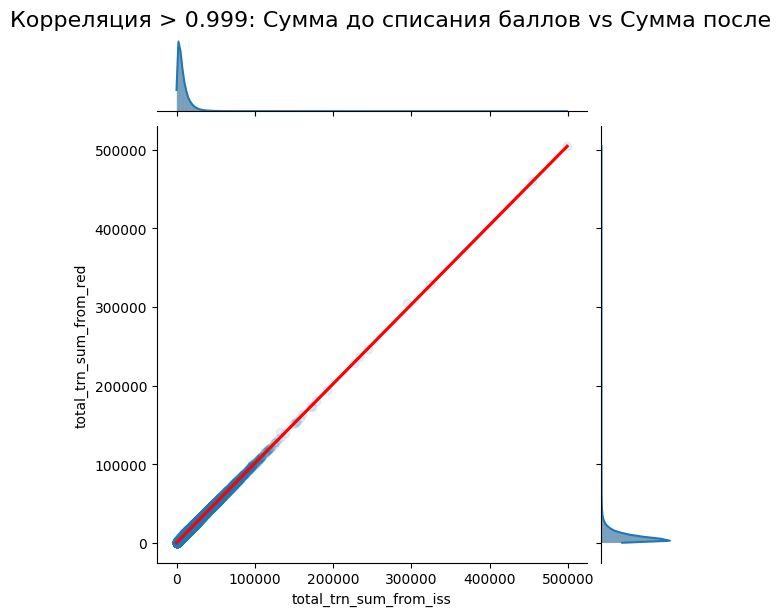

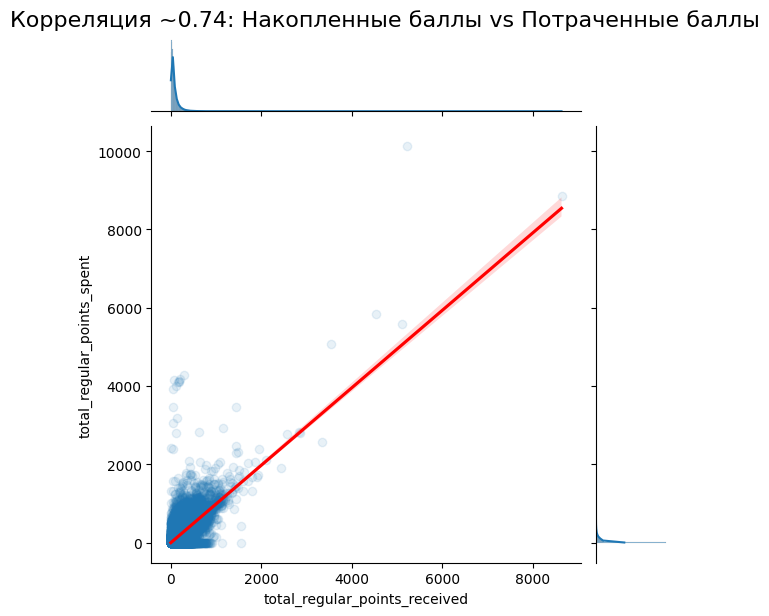

In [26]:
# Пара с самой сильной связью (почти 1.0)
# total_trn_sum_from_iss vs total_trn_sum_from_red
sns.jointplot(data=final_df_for_analysis, 
              x='total_trn_sum_from_iss', 
              y='total_trn_sum_from_red', 
              kind='reg',
              joint_kws={'line_kws':{'color':'red'}, 'scatter_kws': {'alpha': 0.1}})
plt.suptitle('Корреляция > 0.999: Сумма до списания баллов vs Сумма после', y=1.02, fontsize=16)
plt.show()


# Пара с интересной связью
# total_regular_points_received vs total_regular_points_spent
sns.jointplot(data=final_df_for_analysis, 
              x='total_regular_points_received', 
              y='total_regular_points_spent', 
              kind='reg',
              joint_kws={'line_kws':{'color':'red'}, 'scatter_kws': {'alpha': 0.1}})
plt.suptitle('Корреляция ~0.74: Накопленные баллы vs Потраченные баллы', y=1.02, fontsize=16)
plt.show()

### Выводы по анализу корреляций

На основе тепловой карты и программного поиска пар с абсолютным коэффициентом корреляции > 0.7, мы выделили несколько ключевых "кластеров" признаков и сделали некоторые выводы.

**Кластер 1: Абсолютная корреляция > 0.95**

Эта группа признаков демонстрирует почти идеальную линейную зависимость, что говорит о функциональной связи.

-   Корреляции между признаками `total_purchase_sum`, `total_trn_sum_from_iss`, `total_trn_sum_from_red` превышают 0.99. Эти признаки являются разными  измерениями общего объема трат клиента. Наиболее ценную информацию в себе несет `total_purchase_sum` - общая сумма покупки.
-   `avg_transaction_amount` и `transaction_amount_q0.75` (**0.97**), а также для `q0.5` (**0.96**). Средний чек очень сильно определяется медианой и верхним квантилем, что указывает на относительную стабильность трат у клиентов.

В дальнейшем оставлять эту группу нельзя в связи с тем, что это вызовет мультиколлинеарность, которая сломает линейную модель. Поэтому стоит выделить по одному представителю для каждой из подгрупп.

**Кластер 2: Абсолютная корреляция 0.8 - 0.95**

Эта группа обладает сильной структурной связью.

-   `total_purchase_sum` vs `total_regular_points_received` (**0.91**): Прямое отражение механики программы лояльности.
-   `total_purchase_sum` vs `total_products_purchased` (**0.93**): Клиенты, тратящие больше, покупают больше товаров.
-   `total_purchase_sum` vs `unique_products_count` (**0.86**): Покупатели с большим оборотом также имеют более широкие интересы.
-   `avg_transaction_amount` vs `avg_regular_points_per_transaction` (**0.87**): Отражение той же механики лояльности, но на уровне среднего чека.

Аналогично первой группе, эта группа также содержит высокую степень избыточности, так как признаки несут очень похожую информацию и вызывают мультиколлинеарность, хотя и не идентичны.

**Кластер 3: Абсолютная корреляция 0.7 - 0.8**

Интересный диапазон корреляций, так как связи в нем связи имеют уже поведенческий характер и могут раскрывать интересные инсайты.

-   `total_regular_points_received` vs `total_regular_points_spent` (**0.74**): Данная пара показывает, что клиенты, которые активно копят баллы, также активно их и тратят. 
-   `total_express_points_received` vs `avg_express_points_per_transaction` (**0.78**): Связь между общим количеством экспресс-баллов и их средним начислением за транзакцию.

Признаки в этой группе менее избыточны и могут в дальнейшем представлять пользу для модели. Особенно стоит обратить внимание на пару `total_regular_points_received` vs `total_regular_points_spent`, так как она несет информацию о действии списания, а не просто о накоплении, что может быть ценным для модели, несмотря на корреляцию.

Для сохранения интерпретируемости признаков, на данном этапе мы не будем пользоваться PCA, ограничившись корректировками исходя корреляционного анализа. 

Удалим два признака, дублирующие метрики баллов в отношении к товару (`total_trn_sum_from_iss` и `total_trn_sum_from_red`). Из метрик среднего чека оставим квантиль 0.5, так как он характеризует стабильность покупок клиента и их разброс. На основе среднего чека выделим меру того, сколько в среднем сохраняет стоимости покупки один бонусный балл - `avg_transaction_amount_per_point`. И выделим из метрик трат баллов общий баланс на клиента.

In [27]:
# Определим, какие бизнес-метрики мы полагаем объединить для получения новых признаков
final_df_for_analysis['total_purchase_sum_per_product'] = final_df_for_analysis['total_purchase_sum']/final_df_for_analysis['total_products_purchased']
final_df_for_analysis['total_regular_points_balance'] = final_df_for_analysis['total_regular_points_received']-final_df_for_analysis['total_regular_points_spent']
final_df_for_analysis['total_express_points_balance'] = final_df_for_analysis['total_express_points_received']-final_df_for_analysis['total_express_points_spent']
final_df_for_analysis['avg_transaction_amount_per_point'] = final_df_for_analysis['avg_transaction_amount']/final_df_for_analysis['avg_regular_points_per_transaction']
final_df_for_analysis_reducted = final_df_for_analysis.drop(
    columns = ['total_trn_sum_from_iss','total_trn_sum_from_red',
             'transaction_amount_q0.75','transaction_amount_q0.25','total_purchase_sum','total_products_purchased',
             'avg_regular_points_per_transaction','total_regular_points_received',
             'total_regular_points_spent','total_express_points_received','total_express_points_spent',
             'avg_transaction_amount','avg_regular_points_per_transaction'])

ЗДЕСЬ НУЖНО ПОСМОТРЕТЬ КОРРЕЛЯЦИЮ НЕЧИСЛОВЫХ ПРИЗНАКОВ....

# Распределение таргета по признакам и тритменту

In [28]:
from sklearn.metrics import roc_auc_score

In [29]:
class TargetScore:
    """ numeric: |Pearson r|, binary: |phi|, categorical: eta^2  + SMD + AUC  -> combined """

    def __init__(self, target_col: str, ignore_dates: bool=True, min_cat_freq: float=0.005, rare_label="__RARE__"):
        self.t, self.ignore_dates, self.min_cat_freq, self.rare = target_col, ignore_dates, min_cat_freq, rare_label

    def summarize(self, df: pd.DataFrame) -> pd.DataFrame:
        y = pd.to_numeric(df[self.t], errors="coerce").astype(float)
        rows = []
        for f in (c for c in df.columns if c != self.t):
            s, kind = df[f], self._kind(df[f])
            if kind=="datetime" and self.ignore_dates: 
                continue

            if kind=="numeric":
                x = pd.to_numeric(s, errors="coerce")
                r   = self._corr(x, y)# [-1,1]
                smd = self._smd(x, y)# effect size
                auc = self._auc(x, y)# [0,1]
                eta2 = np.nan

            elif kind=="binary":
                xb  = pd.to_numeric(s, errors="coerce").astype(float)
                r   = self._corr(xb, y)# phi
                smd = self._smd(xb, y)
                auc = self._auc(xb, y)
                eta2 = np.nan

            else:  # categorical
                x = self._collapse_rare(s)
                eta2 = self._eta2(x, y)# [0,1]
                tr = y.groupby(x).mean(); score = x.map(tr)# AUC по TR
                r, smd, auc = np.nan, np.nan, self._auc(score, y)

            corr = abs(r) if np.isfinite(r) else (eta2 if np.isfinite(eta2) else 0.0)
            auc_n = np.nan if not np.isfinite(auc) else abs(auc-0.5)*2.0# [0,1]
            smd_n = np.nan if not np.isfinite(smd) else np.clip(abs(smd)/0.8,0,1)
            parts = [p for p in (corr, auc_n, smd_n) if np.isfinite(p)]
            rows.append(dict(
                feature=f, kind=kind, score=corr, sign=r, auc=auc, auc_norm=auc_n,
                smd=smd, smd_norm=smd_n, eta2=eta2, combined=(np.mean(parts) if parts else np.nan),
                eff_n=float(s.notna().mean())
            ))
        return pd.DataFrame(rows).sort_values("combined", ascending=False).reset_index(drop=True)

    def plot_ranked(self, summary: pd.DataFrame, by="combined", top_k=25, title=None):
        if summary.empty: print("summary пуст."); return
        sub = summary.sort_values(by, ascending=False).head(top_k).iloc[::-1]
        pal = {"numeric":"#5B8FF9","binary":"#5AD8A6","categorical":"#F6BD16"}
        plt.figure(figsize=(12, max(5, 0.45*len(sub))))
        ax = sns.barplot(x=by, y="feature", data=sub, hue="kind", dodge=False, palette=pal)
        if by in {"score","auc_norm","smd_norm","combined"}: ax.set_xlim(0,1)
        ax.set_title(title or f"Топ-{len(sub)} по {by}"); ax.set_xlabel(by); ax.set_ylabel(""); ax.legend(title="Тип")
        for p in ax.patches:
            w=p.get_width()
            if np.isfinite(w) and w>0: ax.text(w+0.01, p.get_y()+p.get_height()/2, f"{w:.3f}", va="center", fontsize=9)
        sns.despine(); plt.tight_layout(); plt.show()

    def plot_bubble(self, summary: pd.DataFrame, title="AUC vs SMD (норм.)"):
        sub = summary.copy()
        sub = sub[(sub["auc_norm"].notna()) | (sub["smd_norm"].notna())]
        if sub.empty: print("нет данных"); return
        sub["auc_norm"] = sub["auc_norm"].fillna(0.0); sub["smd_norm"]=sub["smd_norm"].fillna(0.0)
        pal = {"numeric":"#5B8FF9","binary":"#5AD8A6","categorical":"#F6BD16"}
        sizes = 80 + 420*sub["eff_n"].clip(0,1)
        plt.figure(figsize=(10,7))
        for k,g in sub.groupby("kind"):
            plt.scatter(g["auc_norm"], g["smd_norm"], s=sizes[g.index], c=pal.get(k,"#BFBFBF"),
                        alpha=0.75, edgecolor="white", linewidth=0.5, label=k)
        thr = sub["combined"].quantile(0.85)
        for _,r in sub[sub["combined"]>=thr].iterrows():
            plt.text(r["auc_norm"]+0.01, r["smd_norm"]+0.01, r["feature"], fontsize=8)
        plt.xlabel("|AUC-0.5|*2"); plt.ylabel("|SMD|/0.8"); plt.xlim(-0.02,1.02); plt.ylim(-0.02,1.02)
        plt.title(title); plt.grid(alpha=0.3); plt.legend(title="Тип"); plt.tight_layout(); plt.show()


    def _kind(self, s: pd.Series) -> str:
        if pd.api.types.is_datetime64_any_dtype(s): return "datetime"
        if pd.api.types.is_bool_dtype(s): return "binary"
        if pd.api.types.is_numeric_dtype(s):
            vals = pd.Series(s).dropna().unique()
            return "binary" if len(vals)<=2 and set(pd.Series(vals).astype(float))<={0.0,1.0} else "numeric"
        return "categorical"

    def _collapse_rare(self, s: pd.Series) -> pd.Series:
        vc = s.value_counts(normalize=True); rare = vc[vc<self.min_cat_freq].index
        if len(rare)==0: return s
        x = s.astype(object).copy(); x.loc[x.isin(rare)] = self.rare; return x

    def _corr(self, a: pd.Series, b: pd.Series) -> float:
        a = pd.to_numeric(a, errors="coerce").astype(float); b = pd.to_numeric(b, errors="coerce").astype(float)
        m = a.notna() & b.notna(); a,b = a[m], b[m]
        if a.size<3 or np.isclose(a.std(ddof=0),0) or np.isclose(b.std(ddof=0),0): return np.nan
        return float(a.corr(b))

    def _eta2(self, x: pd.Series, y: pd.Series) -> float:
        y = pd.to_numeric(y, errors="coerce").astype(float); var = y.var()
        if not np.isfinite(var) or np.isclose(var,0): return np.nan
        means = y.groupby(x).mean(); w = x.value_counts(normalize=True).reindex(means.index).fillna(0.0)
        return float(((means - y.mean())**2 * w).sum()/var)

    def _smd(self, x: pd.Series, y: pd.Series) -> float:
        x = pd.to_numeric(x, errors="coerce"); y = pd.to_numeric(y, errors="coerce").astype(int)
        x0,x1 = x[y==0].dropna(), x[y==1].dropna()
        if len(x0)<2 or len(x1)<2: return np.nan
        m0,m1 = x0.mean(), x1.mean(); s0,s1 = x0.std(ddof=1), x1.std(ddof=1)
        pooled = np.sqrt((s0**2+s1**2)/2.0); 
        return np.nan if not np.isfinite(pooled) or pooled==0 else float((m1-m0)/pooled)

    def _auc(self, x: pd.Series, y: pd.Series) -> float:
        x = pd.to_numeric(x, errors="coerce"); y = pd.to_numeric(y, errors="coerce").round().astype(int)
        m = x.notna() & y.notna(); x,y = x[m], y[m]
        if x.nunique()<2 or y.nunique()<2: return np.nan
        try: return float(roc_auc_score(y, x))
        except: return np.nan


In [30]:
import warnings
warnings.filterwarnings('ignore')

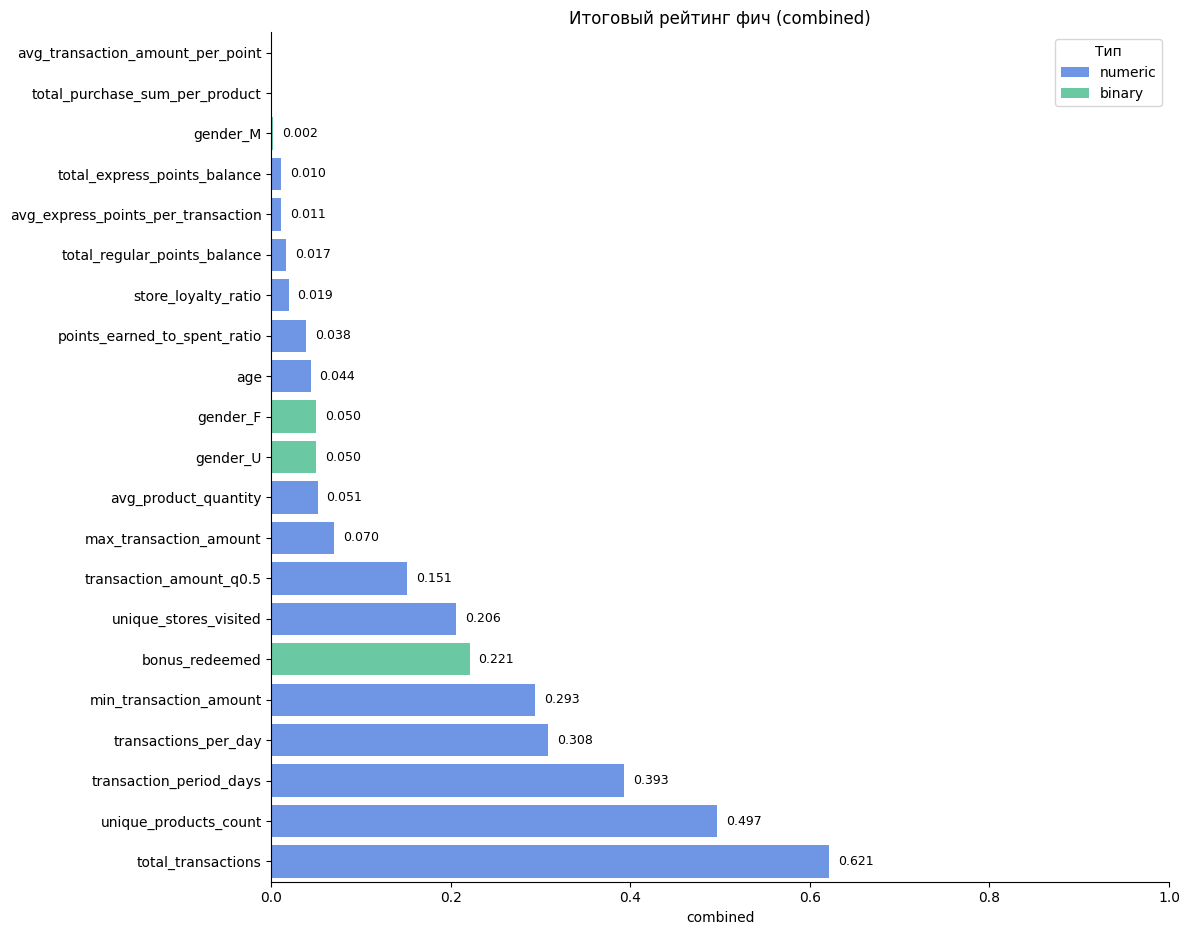

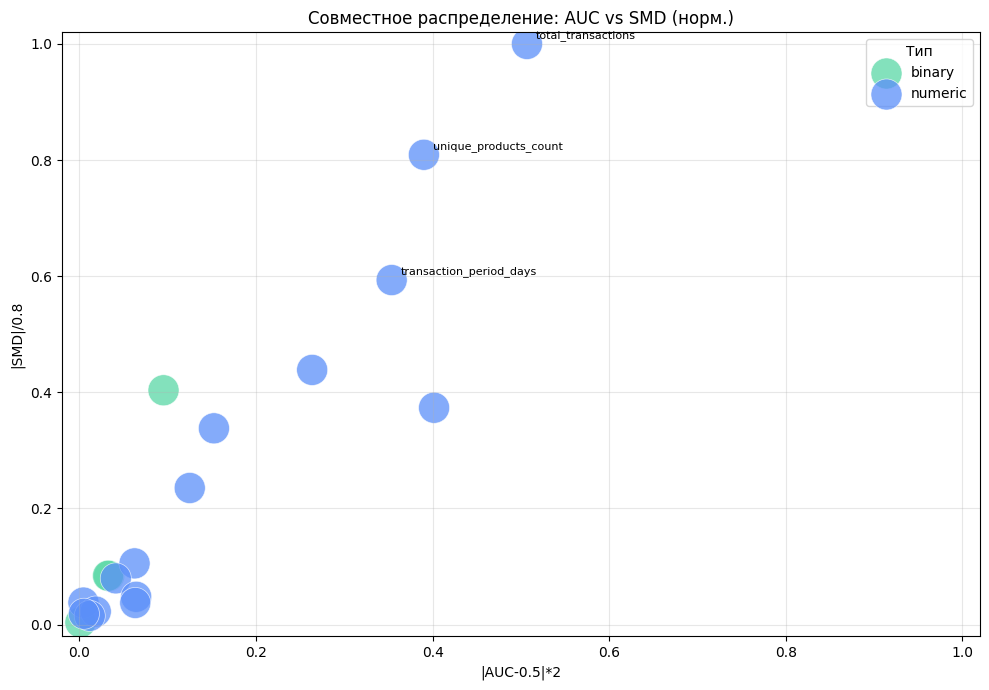

In [31]:
df_eval = final_df_for_analysis_reducted.drop(columns=["treatment_flg"], errors="ignore")
ts = TargetScore(target_col="target", ignore_dates=True)

summary = ts.summarize(df_eval)
ts.plot_ranked(summary, by="combined", top_k=30, title="Итоговый рейтинг фич (combined)")
ts.plot_bubble(summary, title="Совместное распределение: AUC vs SMD (норм.)")


In [32]:
summary

,feature,kind,score,sign,auc,auc_norm,smd,smd_norm,eta2,combined,eff_n
0,total_transactions,numeric,0.356609,0.356609,0.753445,0.506890,0.836036,1.000000,NaN,0.621166,1.0
1,unique_products_count,numeric,0.290271,0.290271,0.695076,0.390153,0.647297,0.809121,NaN,0.496515,1.0
2,transaction_period_days,numeric,0.230674,0.230674,0.676821,0.353642,0.474709,0.593386,NaN,0.392567,1.0
3,transactions_per_day,numeric,0.148106,0.148106,0.700841,0.401683,0.298752,0.373440,NaN,0.307743,1.0
4,min_transaction_amount,numeric,0.178185,-0.178185,0.368203,0.263594,-0.350899,0.438623,NaN,0.293468,1.0
5,bonus_redeemed,binary,0.163448,0.163448,0.547625,0.095250,0.322858,0.403573,NaN,0.220757,1.0
6,unique_stores_visited,numeric,0.127131,0.127131,0.576172,0.152343,0.270446,0.338058,NaN,0.205844,1.0
7,transaction_amount_q0.5,numeric,0.092721,-0.092721,0.437520,0.124961,-0.188227,0.235283,NaN,0.150988,1.0
8,max_transaction_amount,numeric,0.040736,0.040736,0.531220,0.062440,0.084351,0.105439,NaN,0.069539,1.0
9,avg_product_quantity,numeric,0.033163,-0.033163,0.479416,0.041167,-0.063714,0.079642,NaN,0.051324,1.0


### Теперь посмотрим на распределение в группах по тритменту:

In [33]:
# сравнение информативности признаков между treatment-группами 

ts_treat = TargetScore(target_col="target", ignore_dates=True, min_cat_freq=0.005)

summary_t0 = ts_treat.summarize(final_df_for_analysis_reducted.query("treatment_flg == 0"))
summary_t1 = ts_treat.summarize(final_df_for_analysis_reducted.query("treatment_flg == 1"))

# Сопоставляем фичи из обеих таблиц
cols = ["feature", "kind", "score", "auc_norm", "smd_norm", "combined"]
cmp = (summary_t0[cols].merge(summary_t1[["feature","score","auc_norm","smd_norm","combined"]],
                              on="feature", suffixes=("_t0","_t1")))

# Дельты (подписанные и абсолютные)
for m in ["score","auc_norm","smd_norm","combined"]:
    cmp[f"delta_{m}"] = cmp[f"{m}_t1"] - cmp[f"{m}_t0"]
    cmp[f"delta_{m}_abs"] = cmp[f"delta_{m}"].abs()

# Сортируем по расхождению интегральной метрики
cmp_sorted = cmp.sort_values("delta_combined_abs", ascending=False).reset_index(drop=True)

# Итоговая таблица сравнения
cmp_sorted.head(30)


,feature,kind,score_t0,auc_norm_t0,smd_norm_t0,combined_t0,score_t1,auc_norm_t1,smd_norm_t1,combined_t1,delta_score,delta_score_abs,delta_auc_norm,delta_auc_norm_abs,delta_smd_norm,delta_smd_norm_abs,delta_combined,delta_combined_abs
0,unique_products_count,numeric,0.301849,0.403705,0.834389,0.513314,0.278632,0.376729,0.784205,0.479855,-0.023216,0.023216,-0.026976,0.026976,-0.050184,0.050184,-0.033459,0.033459
1,max_transaction_amount,numeric,0.049016,0.077202,0.125783,0.084000,0.032235,0.047091,0.084279,0.054535,-0.016781,0.016781,-0.030111,0.030111,-0.041505,0.041505,-0.029465,0.029465
2,age,numeric,0.014156,0.046896,0.035491,0.032181,0.025800,0.082128,0.070662,0.059530,0.011644,0.011644,0.035233,0.035233,0.035171,0.035171,0.027349,0.027349
3,bonus_redeemed,binary,0.155655,0.091521,0.385010,0.210729,0.171065,0.098862,0.421720,0.230549,0.015411,0.015411,0.007341,0.007341,0.036709,0.036709,0.019820,0.019820
4,gender_F,binary,0.026750,0.026364,0.068480,0.040531,0.038467,0.038593,0.100348,0.059136,0.011717,0.011717,0.012229,0.012229,0.031868,0.031868,0.018605,0.018605
5,transaction_amount_q0.5,numeric,0.089498,0.112868,0.225562,0.142643,0.096275,0.137810,0.246370,0.160152,0.006778,0.006778,0.024942,0.024942,0.020808,0.020808,0.017509,0.017509
6,unique_stores_visited,numeric,0.133326,0.157999,0.351861,0.214395,0.120933,0.146852,0.324135,0.197307,-0.012393,0.012393,-0.011147,0.011147,-0.027725,0.027725,-0.017088,0.017088
7,gender_U,binary,0.028291,0.028842,0.072286,0.043140,0.036949,0.038306,0.096022,0.057093,0.008658,0.008658,0.009464,0.009464,0.023736,0.023736,0.013953,0.013953
8,total_express_points_balance,numeric,0.025803,0.006913,0.065759,0.032825,0.011857,0.017499,0.031137,0.020164,-0.013946,0.013946,0.010586,0.010586,-0.034622,0.034622,-0.012661,0.012661
9,transaction_period_days,numeric,0.235422,0.357717,0.603332,0.398824,0.225795,0.349910,0.583986,0.386564,-0.009627,0.009627,-0.007806,0.007806,-0.019347,0.019347,-0.012260,0.012260


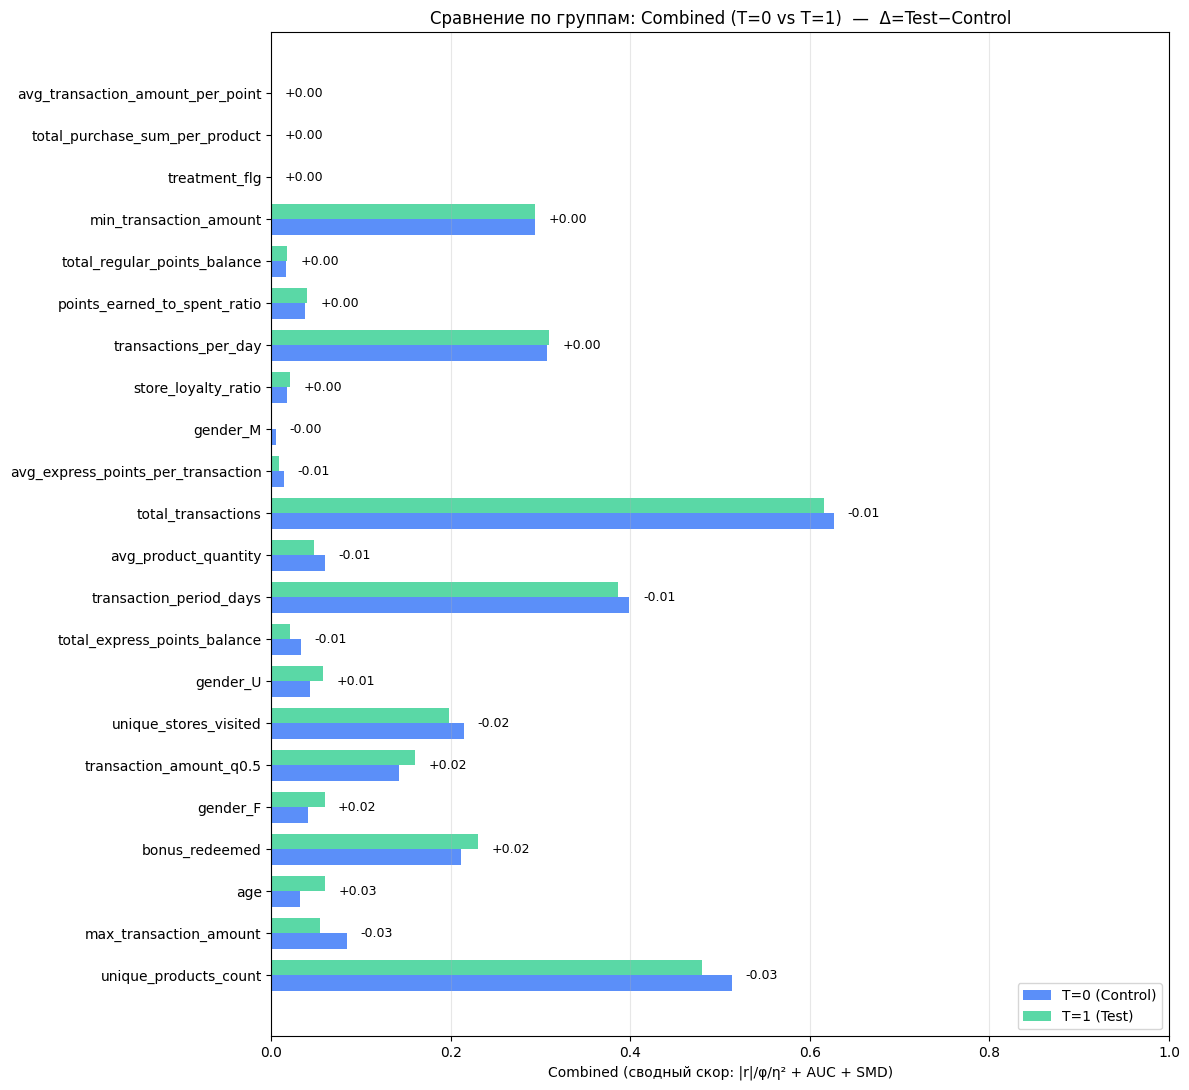

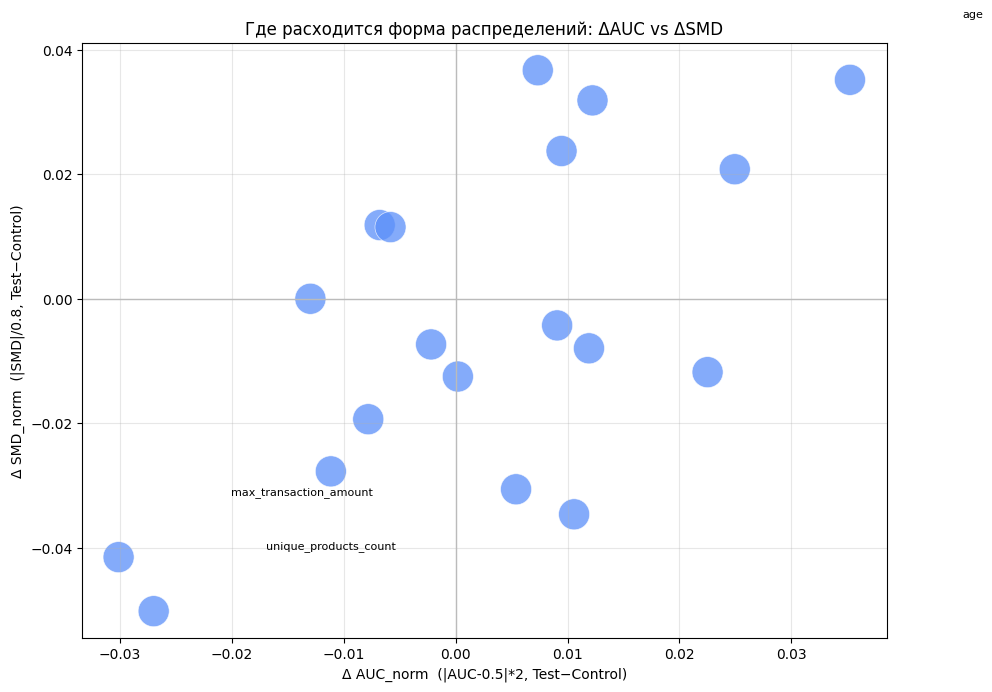

In [34]:
top_k = 25
top = cmp_sorted.head(top_k)
plt.figure(figsize=(12, max(6, 0.5*len(top))))
y = np.arange(len(top)); w = 0.37

plt.barh(y - w/2, top["combined_t0"], height=w, color="#5B8FF9", label="T=0 (Control)")
plt.barh(y + w/2, top["combined_t1"], height=w, color="#5AD8A6", label="T=1 (Test)")

# подпишем Δcombined справа от большего столбца
for i, d in enumerate(top["delta_combined"]):
    mx = max(top["combined_t0"].iloc[i], top["combined_t1"].iloc[i])
    plt.text(mx + 0.015, i, f"{d:+.2f}", va="center", fontsize=9)

plt.yticks(y, top["feature"])
plt.xlabel("Combined (сводный скор: |r|/φ/η² + AUC + SMD)")
plt.title("Сравнение по группам: Combined (T=0 vs T=1)  —  Δ=Test−Control")
plt.xlim(0, 1); plt.grid(axis="x", alpha=0.3); plt.legend(loc="lower right")
plt.tight_layout(); plt.show()

# Пузырьки: ΔAUC vs ΔSMD (норм.)
bubble = cmp_sorted.copy()
bubble = bubble[(bubble["auc_norm_t0"].notna() | bubble["auc_norm_t1"].notna() |
                 bubble["smd_norm_t0"].notna() | bubble["smd_norm_t1"].notna())]

if not bubble.empty:
    sizes = 80 + 420 * (summary_t0.set_index("feature").loc[bubble["feature"], "eff_n"].values.clip(0,1))
    plt.figure(figsize=(10, 7))
    plt.scatter(bubble["delta_auc_norm"], bubble["delta_smd_norm"], s=sizes, alpha=0.75,
                edgecolor="white", linewidth=0.5, c="#5B8FF9")
    # подпишем топ-15% по |Δcombined|
    thr = bubble["delta_combined_abs"].quantile(0.85)
    lab = bubble[bubble["delta_combined_abs"] >= thr]
    for _, r in lab.iterrows():
        plt.text(r["delta_auc_norm"]+0.01, r["delta_smd_norm"]+0.01, r["feature"], fontsize=8)

    plt.axvline(0, color="#BBBBBB", lw=1); plt.axhline(0, color="#BBBBBB", lw=1)
    plt.xlabel("Δ AUC_norm  (|AUC-0.5|*2, Test−Control)")
    plt.ylabel("Δ SMD_norm  (|SMD|/0.8, Test−Control)")
    plt.title("Где расходится форма распределений: ΔAUC vs ΔSMD")
    plt.grid(alpha=0.3); plt.tight_layout(); plt.show()


# Распределение таргета по тритменту

Распределение таргета по тритменту (%):
target               0.0        1.0
treatment_flg                      
0.0            39.671990  60.328010
1.0            36.348906  63.651094

Абсолютные значения:
target           0.0    1.0
treatment_flg              
0.0            39695  60363
1.0            36342  63639


<Figure size 1000x600 with 0 Axes>

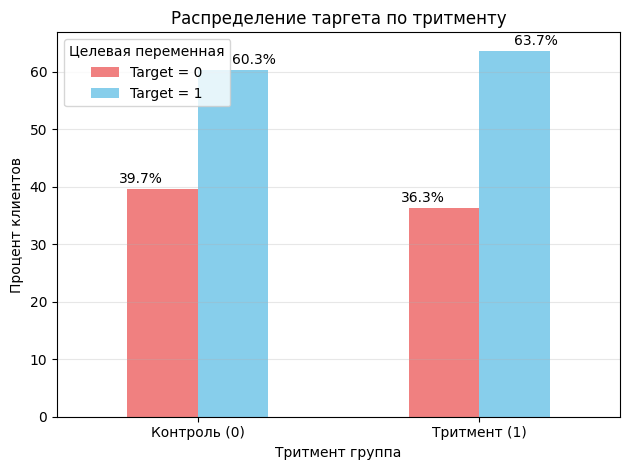


Дополнительная статистика:
Общий размер выборки: 200039
Размер контрольной группы: 100058
Размер тритмент группы: 99981
Общая конверсия: 0.620
Конверсия в контрольной группе: 0.603
Конверсия в тритмент группе: 0.637


In [35]:
plt.figure(figsize=(10, 6))

# создание сводной таблицы
target_by_treatment = pd.crosstab(final_df_for_analysis['treatment_flg'], 
                                  final_df_for_analysis['target'], 
                                  normalize='index') * 100

print("Распределение таргета по тритменту (%):")
print(target_by_treatment)
print("\nАбсолютные значения:")
print(pd.crosstab(final_df_for_analysis['treatment_flg'], final_df_for_analysis['target']))

# визуализация
target_by_treatment.plot(kind='bar', color=['lightcoral', 'skyblue'])
plt.title('Распределение таргета по тритменту')
plt.xlabel('Тритмент группа')
plt.ylabel('Процент клиентов')
plt.xticks([0, 1], ['Контроль (0)', 'Тритмент (1)'], rotation=0)
plt.legend(['Target = 0', 'Target = 1'], title='Целевая переменная')
plt.grid(axis='y', alpha=0.3)

# подписи с процентами
for i, (idx, row) in enumerate(target_by_treatment.iterrows()):
    plt.text(i - 0.2, row[0] + 1, f'{row[0]:.1f}%', ha='center')
    plt.text(i + 0.2, row[1] + 1, f'{row[1]:.1f}%', ha='center')

plt.tight_layout()
plt.show()

# доп статистика
print("\nДополнительная статистика:")
print(f"Общий размер выборки: {len(final_df_for_analysis)}")
print(f"Размер контрольной группы: {len(final_df_for_analysis[final_df_for_analysis['treatment_flg'] == 0])}")
print(f"Размер тритмент группы: {len(final_df_for_analysis[final_df_for_analysis['treatment_flg'] == 1])}")
print(f"Общая конверсия: {final_df_for_analysis['target'].mean():.3f}")
print(f"Конверсия в контрольной группе: {final_df_for_analysis[final_df_for_analysis['treatment_flg'] == 0]['target'].mean():.3f}")
print(f"Конверсия в тритмент группе: {final_df_for_analysis[final_df_for_analysis['treatment_flg'] == 1]['target'].mean():.3f}")

# Статистическая значимость зависимости таргета от тритмента

Данные для статистического теста:
Тритмент группа: 63639.0 успехов из 99981 (конверсия: 0.637)
Контрольная группа: 60363.0 успехов из 100058 (конверсия: 0.603)

Результаты Z-теста для пропорций:
Z-статистика: 15.3093
P-value: 0.0000

Результаты T-теста:
T-статистика: 15.3182
P-value: 0.0000

95% доверительные интервалы:
Контрольная группа: [0.600, 0.606]
Тритмент группа: [0.634, 0.639]


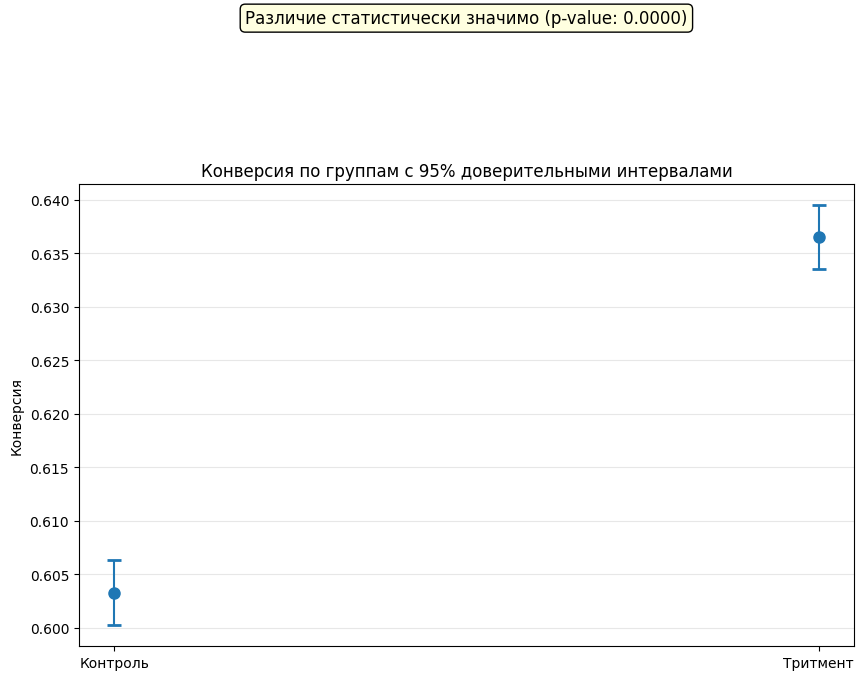


ИНТЕРПРЕТАЦИЯ РЕЗУЛЬТАТОВ:
Различие между группами СТАТИСТИЧЕСКИ ЗНАЧИМО (p-value = 0.0000)
Uplift эффект: 5.51%
Тритмент увеличивает конверсию на 3.32 процентных пунктов

Уровень значимости: α = 0.05


In [37]:
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest

# подготовка данных для теста
control_group = final_df_for_analysis[final_df_for_analysis['treatment_flg'] == 0]
treatment_group = final_df_for_analysis[final_df_for_analysis['treatment_flg'] == 1]

successes = [treatment_group['target'].sum(), control_group['target'].sum()]
nobs = [len(treatment_group), len(control_group)]

print("Данные для статистического теста:")
print(f"Тритмент группа: {successes[0]} успехов из {nobs[0]} (конверсия: {successes[0]/nobs[0]:.3f})")
print(f"Контрольная группа: {successes[1]} успехов из {nobs[1]} (конверсия: {successes[1]/nobs[1]:.3f})")

# Z-тест для пропорций
z_stat, p_value = proportions_ztest(successes, nobs)
print(f"\nРезультаты Z-теста для пропорций:")
print(f"Z-статистика: {z_stat:.4f}")
print(f"P-value: {p_value:.4f}")

# T-тест для дополнительной проверки
t_stat, p_value_t = stats.ttest_ind(treatment_group['target'], control_group['target'])
print(f"\nРезультаты T-теста:")
print(f"T-статистика: {t_stat:.4f}")
print(f"P-value: {p_value_t:.4f}")

# расчет доверительных интервалов
from statsmodels.stats.proportion import proportion_confint

conf_int_control = proportion_confint(successes[1], nobs[1], alpha=0.05, method='normal')
conf_int_treatment = proportion_confint(successes[0], nobs[0], alpha=0.05, method='normal')

print(f"\n95% доверительные интервалы:")
print(f"Контрольная группа: [{conf_int_control[0]:.3f}, {conf_int_control[1]:.3f}]")
print(f"Тритмент группа: [{conf_int_treatment[0]:.3f}, {conf_int_treatment[1]:.3f}]")

# визуализация результатов теста
plt.figure(figsize=(10, 6))

# точечная оценка и доверительные интервалы
groups = ['Контроль', 'Тритмент']
means = [successes[1]/nobs[1], successes[0]/nobs[0]]
conf_intervals = [
    [conf_int_control[0], conf_int_control[1]],
    [conf_int_treatment[0], conf_int_treatment[1]]
]

plt.errorbar(groups, means, 
             yerr=[means[0] - conf_intervals[0][0], means[1] - conf_intervals[1][0]], 
             fmt='o', capsize=5, capthick=2, markersize=8)
plt.title('Конверсия по группам с 95% доверительными интервалами')
plt.ylabel('Конверсия')
plt.grid(axis='y', alpha=0.3)

# аннотация о статзначимости
significance = "статистически значимо" if p_value < 0.05 else "не статистически значимо"
plt.text(0.5, max(means) + 0.02, f'Различие {significance} (p-value: {p_value:.4f})', 
         ha='center', fontsize=12, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightyellow"))

plt.show()

# интерпретация результатов
print("\nИНТЕРПРЕТАЦИЯ РЕЗУЛЬТАТОВ:")
if p_value < 0.05:
    uplift = (means[1] - means[0]) / means[0] * 100
    print(f"Различие между группами СТАТИСТИЧЕСКИ ЗНАЧИМО (p-value = {p_value:.4f})")
    print(f"Uplift эффект: {uplift:.2f}%")
    print(f"Тритмент увеличивает конверсию на {(means[1] - means[0])*100:.2f} процентных пунктов")
else:
    print(f"Различие между группами НЕ СТАТИСТИЧЕСКИ ЗНАЧИМО (p-value = {p_value:.4f})")
    print("Нет достаточных доказательств влияния тритмента на целевую переменную")

print(f"\nУровень значимости: α = 0.05")

# Балансировка контрольной и таргет групп

Здесь нужно выбрать только значимые фичи, убрать мультиколлинеарность, посчитать пропенсити скор и распределения по нему, оценить сбалансированность групп

In [ ]:
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import roc_auc_score
from scipy.stats import ks_2samp
from sklift.models import ClassTransformationReg

ТУТ БУДЕТ МОДЕЛЬ....